# Create Cervical Cell Polarity Dataset

In [1]:
import os
import imageio
import matplotlib.pyplot as plt
import os
import numpy as np
import imageio
from skimage.measure import regionprops, label
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from utils.DataUtils import *

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

dir_img = '/home/jovyan/discotreino/2DCellPol_Github/cervical/dataset_train/images' #directory with the images 
dir_cyto = '/home/jovyan/discotreino/2DCellPol_Github/cervical/dataset_train/cyto' #directory with the cytoplasm instance masks
dir_nuc = '/home/jovyan/discotreino/2DCellPol_Github/cervical/dataset_train/nucleus' #directory with the nuclei instance masks

save_dir_imgs = r'/home/jovyan/discotreino/2DCellPol_Github/cervical/train/images' #directory where the images will be saved 
save_dir_outputs = r'/home/jovyan/discotreino/2DCellPol_Github/cervical/train/outputs' #directory where the Gaussian heatmaps and embedding maps will be saved

imgs = [f for f in os.listdir(dir_img) if f.endswith('.png')]

for k in imgs:
    image = imageio.imread(os.path.join(dir_img, k))
    cytoplasm = imageio.imread(os.path.join(dir_cyto, k))
    nucleus = imageio.imread(os.path.join(dir_nuc, k))
    
    if len(np.unique(nucleus))>=2:
    
        # Ensure the images are labeled
        labeled_cytoplasm = cytoplasm
        labeled_nucleus = nucleus

        # Compute the region properties (including centroids)
        props_cytoplasm = regionprops(labeled_cytoplasm)
        props_nucleus = regionprops(labeled_nucleus)

        # Extract the centroids
        cytoplasm_centroids = np.array([prop.centroid for prop in props_cytoplasm])
        nucleus_centroids = np.array([prop.centroid for prop in props_nucleus])

        # Compute the cost matrix (Euclidean distance)
        cost_matrix = cdist(nucleus_centroids, cytoplasm_centroids)

        # Solve the assignment problem
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        cnn = []
        cgg = []
        
        for nuc_idx, cyto_idx in zip(row_ind, col_ind):
            cyto_centroid = cytoplasm_centroids[cyto_idx]
            nuc_centroid = nucleus_centroids[nuc_idx]
            
            cnn.append(cyto_centroid)
            cgg.append(nuc_centroid)
            

        image = image.astype('uint8')
        np.save(os.path.join(save_dir_imgs, k.replace('.png', '.npy')), image)

        _slice = image
        centroids_image = np.zeros((np.shape(_slice)[0], np.shape(_slice)[1], 4))
        centroids_image[:,:,1], centroids_image[:,:,3] = centroids2Images(cnn, np.shape(_slice)[0], np.shape(_slice)[1], g_radius=40, th=0.1)
        centroids_image[:,:,0], centroids_image[:,:,2] = centroids2Images(cgg, np.shape(_slice)[0], np.shape(_slice)[1], g_radius=11, th=0.1)
        centroids_image[:,:,1] = 255*centroids_image[:,:,1]
        centroids_image[:,:,0] = 255*centroids_image[:,:,0]
        _mask_slice = centroids_image

        centroids_image = centroids_image.astype('uint8')
        np.save(os.path.join(save_dir_outputs, k.replace('.png', '.npy')), centroids_image)

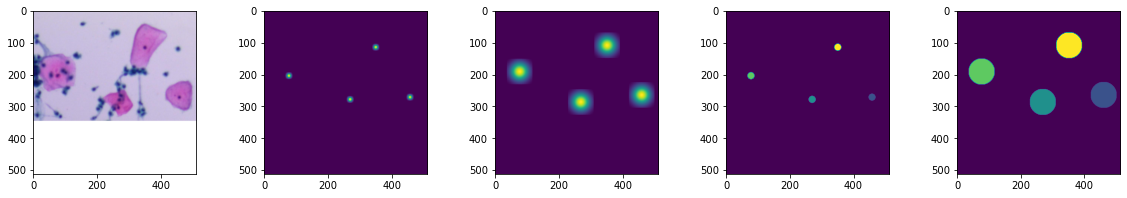

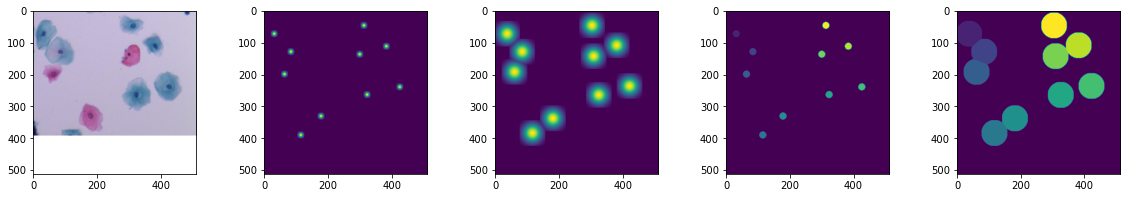

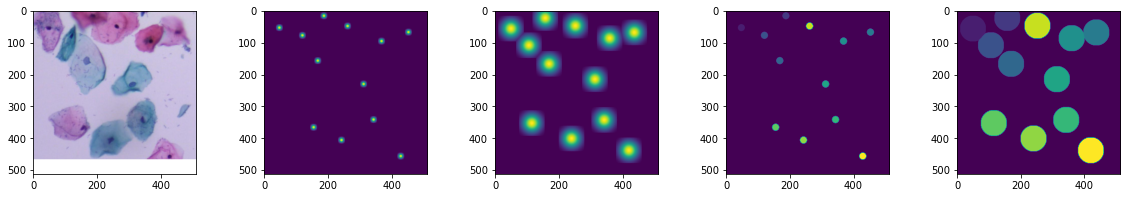

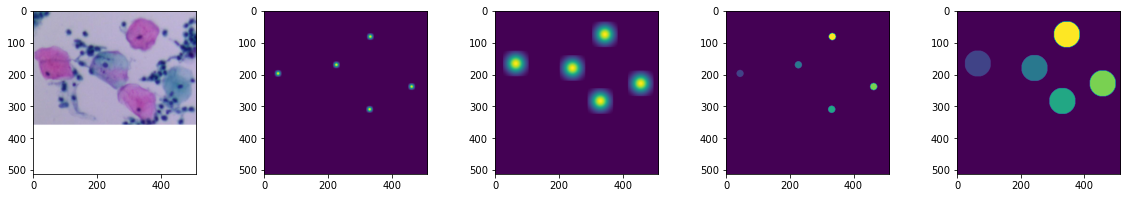

In [2]:
import matplotlib.pyplot as plt
imgs = [f for f in os.listdir(save_dir_imgs) if f.endswith('.npy')]
for k in imgs:
    image = np.load(os.path.join(save_dir_imgs, k))
    gt = np.load(os.path.join(save_dir_outputs, k))
    
    plt.rcParams["figure.figsize"] = (20,3)
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
    ax1.imshow(image)
    ax2.imshow(gt[:,:,0])
    ax3.imshow(gt[:,:,1])
    ax4.imshow(gt[:,:,2])
    ax5.imshow(gt[:,:,3])